# Gambler's problem (Dynamic programming)

In [7]:
# Some useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Introduction and Setup

*(Based on Example 4.3 in Sutton & Barto)*

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake.
The coin has a probability of $p_h = 0.4$ of coming up heads.
The player starts with some integer amount of money between $1 and $99.

The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money.
On each flip, the gambler must decide what portion of his capital to stake, a positive integer number of dollars.
The player cannot cash out, he must play until he wins or loses.
Since there is only a total of $100 at the table, the gambler cannot place a bet that would cause him to have more than $100 after a win.
This problem can be formulated as an undiscounted, episodic, finite MDP. 

Identify the state-space, possible actions (per state), and reward/transition probabilities.

State-space: $ s \in S$ with
$$S = \{ 0, 1, \ldots, 99, 100\} $$

Possible actions in state $s$: $a \in A(s)$ with
$$A(s) = \{ 1, 2, \ldots, \min(s, 100-s)\} $$

Rewards/transition probabilites:
$$ p(s', r|s, a) = ...? $$

$$ p(s + a|s, a) = 0.4 $$
$$ p(s - a|s, a) = 0.6 $$

If $s' = 100$, $R = 1$. For all other states $s'$, $R=0$.

Assign the values mentioned in the description to the constants below. (*Sidenote: in Python, there are no constants, but by convention, we use all caps for variables that are not supposed to be changed.*)

In [8]:
# Money goal to reach
MAX_MONEY = 100

# Possible values of probability of the coin coming up heads
P_HEADS =  0.4

# Small number determining the accuracy of policy evaluation's estimation
THETA = 1e-5

# Discount factor (can be 1, since this is an episodic task)
GAMMA = 1

# A list/array of all possible states
STATES = np.arange(MAX_MONEY + 1)

ACTIONS = np.arange(1, 100)

## 2. Policy Evaluation

In this section we evaluate a given deterministic policy $\pi$ by computing the state-value function $v_{\pi}$.

Define the policy you want to evaluate as an array `policy` of adequate length, where `policy[s]` is the action to take when the gambler's capital is `s`.

Initialize the value function as an array `values` of adequate length, where `values[s]` is the value of state `s`. Make sure that terminal states have value zero.

In [9]:
# Use length `MAX_MONEY + 1` to include the terminal state
policy = [1] * len(STATES) # always bet 1 chf
policy = np.zeros((len(STATES), len(ACTIONS)))
policy[1:100,0] = 1
policy = pd.DataFrame(policy)
policy.rename(columns=dict(zip(range(99), range(1, 100))), inplace=True)
policy

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
values = np.zeros(MAX_MONEY + 1)

First, we implement a helper function that evaluates an action `a` for a given state `s`, using the current value function `currentValues`.

In [11]:
def evalAction(s, a, currentValues):
    # If we are already in a terminal state, return 0
    if s in (0, 100):
        return 0
    
    # Check that s+a and s-a are valid states (optional)
    if s-a < 0 or s+a > MAX_MONEY:
        raise Exception('invalid action/state')

    # Compute and return the expected reward + value of the next state
    if s + a == MAX_MONEY:
        eReward = P_HEADS * 1
    else:
        eReward = 0
    
    eValue = currentValues[(s+a)] * P_HEADS + currentValues[(s-a)] * (1-P_HEADS)

    return GAMMA * eValue + eReward
    

Implement iterative policy evaluation. You can follow the pseudo-code on page 75 in Sutton & Barto.

In [98]:
values = np.zeros(MAX_MONEY + 1)

condition = True
n = 0
while condition:
    n = n+1
    delta = 0
    next_values = np.zeros(MAX_MONEY + 1)
    for s in STATES:
        previous_values = values
        value_s = 0

        for a in ACTIONS:
            policy_proba = policy.loc[s, a]
            try:
                res_eval = evalAction(s, a, previous_values)
            except:
                continue
            value_s = value_s + policy_proba * res_eval

        next_values[s] = value_s
        delta = max(delta, abs(value_s - previous_values[s]))
    values = next_values
    if n % 10 == 0:
        print(f' Iteration {n}: delta = {delta}')
    condition = delta > THETA

 Iteration 10: delta = 0.022295347199999982
 Iteration 20: delta = 0.007099487911296359
 Iteration 30: delta = 0.003582911554265128
 Iteration 40: delta = 0.002025721658941382
 Iteration 50: delta = 0.0012296631676672054
 Iteration 60: delta = 0.0007832957211909575
 Iteration 70: delta = 0.0005166011500353507
 Iteration 80: delta = 0.00034975682035845446
 Iteration 90: delta = 0.00024169207441615548
 Iteration 100: delta = 0.0001697798060796285
 Iteration 110: delta = 0.00012087956026496371
 Iteration 120: delta = 8.703553752259507e-05
 Iteration 130: delta = 6.326624702621131e-05
 Iteration 140: delta = 4.6365245138263456e-05
 Iteration 150: delta = 3.422062766472722e-05
 Iteration 160: delta = 2.5414164120218796e-05
 Iteration 170: delta = 1.8977578836260056e-05
 Iteration 180: delta = 1.4240323761960383e-05
 Iteration 190: delta = 1.0732263479140691e-05
 Iteration 200: delta = 8.1201981743384e-06
 Iteration 210: delta = 6.165723455464622e-06
 Iteration 220: delta = 4.696818897087507

In [14]:
# Loop:
policy = [1 for s in STATES]
policy = [min(s, MAX_MONEY - s) for s in STATES]
values = np.zeros(MAX_MONEY + 1)
while True:
#     delta <- 0
    delta = 0

#     Loop for each s in S:
    for s in STATES:

#         v <- V(s)
        oldvalue = values[s]

#         V(s) <- sum_a ...
        action = policy[s]
        values[s] = evalAction(s, action, values)
#         (this part might require multiple lines of code)

#         delta <- max(delta, |v - V(s)|)
        delta = max(delta, abs(oldvalue - values[s]))

#     until delta < THETA
    if delta < THETA:
        break

Plot the value function you computed above.
Depending on your implementation, it might look nicer to ignore the terminal states (`0`, `MAX_MONEY`).

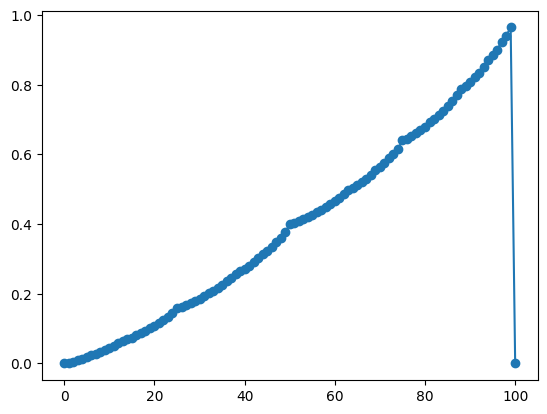

In [15]:
plt.figure()
plt.plot(STATES, values)
plt.scatter(STATES, values)
plt.show()

Does the value function look as expected?
How does the value function change for different policies, probabilities (`P_HEADS`), and discount factors (`GAMMA`)?

## 3. Policy Iteration

In this section, we compute the optimal policy and value function using policy iteration.
We implement the policy evaluation and improvement steps as individual functions, which we then call alternately for the actual policy iteration.



Implement the policy evaluation step. You can use your code from above, but need to wrap it in a function that takes the current policy as an argument.

In [20]:
def policyEvaluation(policy):

    # Loop:
    values = np.zeros(MAX_MONEY + 1)
    while True:
    # delta <- 0
        delta = 0

        # Loop for each s in S:
        for s in STATES:

            # v <- V(s)
            oldvalue = values[s]

            # V(s) <- sum_a ...
            action = policy[s]
            values[s] = evalAction(s, action, values)

            # delta <- max(delta, |v - V(s)|)
            delta = max(delta, abs(oldvalue - values[s]))

        # until delta < THETA
        if delta < THETA:
            break
        
        return values

Implement the policy improvement step as a function that takes the current value function as an argument and returns the new (greedy) policy.

*Note: In this particular example, there are multiple optimal policies. Your results might look nicer if you break ties (or almost ties) in favor of lower stakes.*

In [21]:
def policyImprovement(values):
    for s in STATES:
        if s in (0, MAX_MONEY):
            continue
        best_action = 0
        best_value = -1

        actions = range(1, min(s, MAX_MONEY - s) + 1)
        for action in actions:
            action_value = evalAction(s, action, values)
            if action_value > best_value:
                best_action = action
                best_value = action_value
        
        policy[s] = best_action

    return policy

Implement policy iteration, using the functions you implemented above.

In [22]:
# Initialize values and policy
policy = [1 for s in STATES]
policy[0] = 0
policy[MAX_MONEY] = 0

values = np.zeros(MAX_MONEY + 1)

# Do policy iteration
while True:

    # Policy evaluation
    values = policyEvaluation(policy)

    # Policy improvement
    new_policy = policyImprovement(values)

    # Check if policy has changed
    if policy == new_policy:
        break

    # Update policy
    policy = new_policy

Plot the optimal value function and the optimal policy.

## 4. Value Iteration

In this section we compute the optimal policy and value function using value iteration.
Again, we follow the pseudo-code from Sutton & Barto (p. 83).

In [ ]:
# Initialize values

# Loop:
    # delta <- 0

    # Loop for each s in S:
        # v <- V(s)

        # V(s) <- max_a sum_s' ...
        # (this part might require multiple lines of code)

        # delta <- max(delta, |v - V(s)|)

    # until delta < THETA

# Output a deterministic policy such that
# policy[s] = argmax_a ...
# (this part might require another loop over the states/actions)

Plot the optimal value function and the optimal policy.

In [ ]:
## ...??

### 4.a Bonus

Find and plot *all* optimal policies.

In [ ]:
# Tolerance for "equal" values
TOL_OPTIMAL = 10 * THETA


# Initialize empty policy
# This time, this will be a list of lists
policy = []

# Loop for each state
for state in STATES:
    # If we are in a terminal state, do nothing
    if state == 0 or state == MAX_MONEY:
        policy.append([])
        continue

    # Evaluate all actions
    # ...??
    
    # Choose all optimal actions
    # ...??

    # Append best actions to policy
    # ...??

In [ ]:
# Create scatter plot with all optimal state/action pairs
# ...?

### 4.b Bonus 2

Ideas for further exploration:
- How does the set of *all* optimal policies behave for different values of `MAX_MONEY`? *Hint: Powers of 2 are particularly interesting!*
- Change the code above to allow bets which would cause the player to have more than $100 after a win. Does this change the optimal policy?
- Change the policy evaluation code to allow for non-deterministic policies.